# Approach
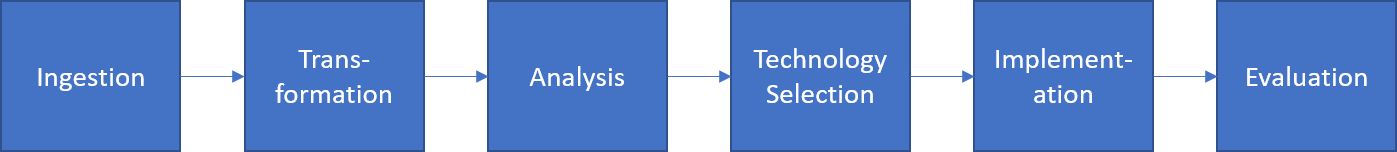


## Assumptions

1. Text comments are in English


## Notes on Related Resources

* [How AI Is Learning to Identify Toxic Online Content](https://www.scientificamerican.com/article/can-ai-identify-toxic-online-content/)
>  This is how our team built Detoxify, an open-source, user-friendly comment detection library to identify inappropriate or harmful text online. Its intended use is to help researchers and practitioners identify potential toxic comments. ... Each model can be easily accessed in one line of code and all models and training code are [publicly available on GitHub (Detoxify)]((https://github.com/unitaryai/detoxify)).

* [Detecting toxic comments with Keras and interpreting the model with ELI5](https://medium.com/@armandj.olivares/detecting-toxic-comments-with-keras-and-interpreting-the-model-with-eli5-dbe734f3e86b) - ([Github](https://github.com/ArmandDS/toxic_detection/blob/master/toxic_detection.ipynb))
> Develop an estimator with a neural network model for a text classification problem and used ELI5 library for explain the predictions



---
# Setups

In [ ]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Global Constant

In [ ]:
# Project ID
PROJECT = "toxic_comment_classification"

# To reduce the data volumen to run through the training in short timeframe.
TEST_MODE = True
NUM_TEST_SAMPLES = 256

## Execution recording (e.g. 2021JUL012322)
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP") 
print(f"Execution timestamp {TIMESTAMP}")

# Directory to manage the data. 
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."
OUTPUT_DIR = "."

# Flag to clear data or not
CLEANING_FOR_ANALYSIS = True
CLEANING_FOR_TRAINING = False

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# Labbels that classifies the type of the comment.
# CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
CATEGORIES = ["toxic"]

Execution timestamp 2021JUL012322


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [ ]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [ ]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = f"/content/drive/MyDrive/home/data/kaggle/{PROJECT}"
    PICKLE_DIR = DATA_DIR
    BASE_DIR = f"/content/drive/MyDrive/home/repository/mon/kaggle/{PROJECT}"
    OUTPUT_DIR = BASE_DIR

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Using Google Colab environment.
Thu Jul  1 23:22:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [ ]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    BASE_DIR = "/kaggle/working"
    PICKLE_DIR = BASE_DIR
    OUTPUT_DIR = BASE_DIR

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm

os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [ ]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install h5py pandas matplotlib 
    !pip install -U spacy
    !python -m spacy download en_core_web_sm
    !python -m spacy validate

## Modules

Install and load Python modules required for the task.

In [ ]:
!pip install -U setuptools wheel
!pip install -U tensorflow transformers scikit-learn 
!pip install -U clean-text unidecode nltk wordcloud gensim
!pip install -U line_profiler memory_profiler

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.8.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.5)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: h5py in /usr/local/lib/python3.7/dist-packages (3.3.0)
Requirement already up-to-date: clean-text in /usr/local/lib/python3.7/dist-packages (0.4.0)
Requirement already up-to-date: unidecode in /usr/local/lib/python3.7/dist-packages (1.2.0)
Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.6.2)
Requirement already up-to-date: wordcloud in /usr/local/lib/python3.7/dist-packages (

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import (
    WordCloud, 
    STOPWORDS
)

## Logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [ ]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Utilities


In [ ]:
SEP = ("".join((["-"] * 80))) + "\n"

# Matplotlib utilities
def plot_on_ax(ax, X, Y, label=None, color=None, title=None, xlabel=None, ylabel=None, legend=True, scale=None, limits=None):
    ax.set_xlim(limits[0:2]) if limits is not None else None
    ax.set_ylim(limits[2:4]) if limits is not None else None
    ax.set_xlabel(xlabel) if xlabel else ...
    ax.set_ylabel(ylabel) if ylabel else ...
    ax.set_title(title) if title is not None else ...
    ax.plot(X, Y, color=color, label=label)
    ax.legend() if legend else None
    ax.grid(which='major', b=False, linestyle='--')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    ax.set_xscale(scale) if scale else ...
    ax.xaxis.get_ticklocs(minor=True)
    ax.minorticks_on()

def hist_on_ax(ax, X, Y, label=None, color=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend=True, scale=None, limits=None):
    ax.set_xlim(limits[0:2]) if limits is not None else None
    ax.set_ylim(limits[2:4]) if limits is not None else None
    ax.set_xlabel(xlabel) if xlabel else ...
    ax.set_ylabel(ylabel) if ylabel else ...
    ax.set_title(title) if title is not None else ...
    ax.hist(Y, bins=X, alpha=alpha, color=color,label=label)
    ax.grid(which='both')
    ax.grid(which='major', b=False, linestyle='--')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    ax.legend() if legend else None
    ax.set_xscale(scale) if scale else ...

def plotter(ax, x, hy, uy, hcolor, ucolor, hlabel, ulabel, xlabel, ylabel, title, limits=None, single=False):
    plot_on_ax(ax, x, hy, color=hcolor, label=hlabel, xlabel=xlabel, ylabel=ylabel, title=title, limits=limits)
    plot_on_ax(ax, x, uy, color=ucolor, label=ulabel) if not single else None
    return
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)       
    plt.title(title, fontsize=20)
    plt.grid()
    ax.legend() if legend else None
    plt.axis(limits) if limits is not None else None

## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [ ]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

## Text Processing

In [ ]:
from cleantext import clean
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Pandas

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [ ]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [ ]:
from transformers import (
    PreTrainedModel,
    DistilBertTokenizerFast,
    TFDistilBertModel,
    TFDistilBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output Directories

In [ ]:
# Result output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
RESULT_DIRECTORY = f"{OUTPUT_DIR}/toxicity_classification_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")
if not os.access(PICKLE_DIR, os.W_OK):
    raise RuntimeError(f"{PICKLE_DIR} not writable")

print(f"DATA_DIR: {DATA_DIR}")
print(f"BASE_DIR: {BASE_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"RESULT_DIRECTORY: {RESULT_DIRECTORY}")

---
# Ingenstion



## Data
### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [ ]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

In [ ]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

Archive:  /content/drive/MyDrive/data/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/drive/MyDrive/data/sample_submission.csv.zip  
  inflating: /content/drive/MyDrive/data/test.csv.zip  
  inflating: /content/drive/MyDrive/data/test_labels.csv.zip  
  inflating: /content/drive/MyDrive/data/train.csv.zip  
Archive:  /content/drive/MyDrive/data/train.csv.zip
  inflating: ./train.csv             
Archive:  /content/drive/MyDrive/data/test.csv.zip
  inflating: ./test.csv              
Archive:  /content/drive/MyDrive/data/test_labels.csv.zip
  inflating: ./test_labels.csv       


## Raw Dataframes

Load the original data from the CSV files into ```raw_``` dataframes.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [ ]:
def load_raw_data(test_mode=False):
    raw_train = pd.read_csv("./train.csv")
    raw_test_data = pd.read_csv("./test.csv")
    raw_test_label = pd.read_csv("./test_labels.csv")
    raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')
    del raw_test_data, raw_test_label

    if TEST_MODE:
        raw_train = raw_train.head(NUM_TEST_SAMPLES)
        raw_test = raw_test.head(NUM_TEST_SAMPLES // 2)

    return raw_train, raw_test

raw_train, raw_test = load_raw_data(TEST_MODE)
print(f"raw_train records: {raw_train['id'].count()} raw_test records: {raw_test['id'].count()}")

### Raw data (train.csv)

In [ ]:
# If in Google colab runtime and got an error, restart the runtime.
# "AttributeError: 'NotebookFormatter' object has no attribute 'get_result'""
# https://stackoverflow.com/questions/66412776
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [ ]:
raw_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
raw_train[raw_train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


### Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [ ]:
#raw_test.describe()
raw_test[(raw_test['toxic'] >= 0)].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
raw_test[(raw_test['toxic'] >= 0)].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


---
# Transformation


In [ ]:
# Keep the raw non-mutated whereas train/test are mutated.
train = raw_train.copy()
test = raw_test.copy()

# To avoid OOM, remove raw_train but keep raw_test for testing/submissin.
del raw_train   
gc.collect()

236

## Enrichment
### Unhealthiness label 

Use the sum of labels as the unhealthiness level of the comment (0: healthy, 6: the most unhealthy). The ```unhealthiness``` is 2 for a comment labeled as ```toxic``` and ```insult```.

In [ ]:
train['unhealthiness'] = train.iloc[:, 1:].sum(axis=1)
train['unhealthy'] = train['unhealthiness'].apply(lambda x: int(x > 0))

### Comment length
Add the comment length to analyze the co-relation the content with its length.

In [ ]:
train['length'] = train['comment_text'].apply(lambda x: len(x))


### Data Argumentation (**Not implemented**)

Permutate the data to provide additional data and address the skewness of the data representation.

* [Data Augmentation in NLP
](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28) - nlpaug
> We explore different authors how they leverage augmentation to tickle NLP tasks via generating more text data to boost up the models.  

* Github [nlpaug](https://github.com/makcedward/nlpaug)
> This python library helps you with augmenting nlp for your machine learning projects. Visit this introduction to understand about Data Augmentation in NLP. Augmenter is the basic element of augmentation while Flow is a pipeline to orchestra multi augmenter together.


## Cleaning

### De-contraction

Restore contraction (e.g. I'll) into de-contracted form (I will) to have the valid words in place.

### Stop words removal

Remove the stop words (e.g. EOL, an, the, us) that has neither positive nor negative influence on the sentence.

* EOL (End of line)
* Numbers, digits
* Email, URL, phone number, currency symbols
* Optional

### Lemmatization
Reducing the inflectional forms (e.g. having, had, has) of a word into its base (have) to focus on the core meaning, not the form of the words.

### Case consistency
Lower the case to remove variations of the same word.


In [ ]:
def decontracted(sentences):
    """Restore the contracted words"""
    # specific
    sentences = re.sub(r"won\'t", "will not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"can\'t", "can not", sentences, flags=re.IGNORECASE)
    # general
    sentences = re.sub(r"n\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'re", " are", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'s", " is", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'d", " would", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ll", " will", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ve", " have", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'m", " am", sentences, flags=re.IGNORECASE)
    return sentences

def remove_noises(sentences):
    """Clean up noises in the text
    Not use no_punct as it is too slow
    """
    sentences = clean(sentences,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,            # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                   # replace all URLs with a special token
        no_emails=True,                 # replace all email addresses with a special token
        no_phone_numbers=True,          # replace all phone numbers with a special token
        no_numbers=True,                # replace all numbers with a special token
        no_digits=True,                 # replace all digits with a special token
        no_currency_symbols=True,       # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="" ,         # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"                       # set to 'de' for German special handling
    )
    # --------------------------------------------------------------------------------
    # Remove punctuations
    # --------------------------------------------------------------------------------
    punctuation = re.escape(string.punctuation)
    pattern = '[%s%s]+' % (punctuation, r'\s')
    sentences = re.sub(pattern, " ", sentences)  
    return sentences

lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    return " ".join([
        lemmatizer.lemmatize(word, pos="v") 
        for word in nltk.word_tokenize(sentence.lower()) 
        if word not in stopwords.words('english')
    ])

def clean_comment_text_without_lemmatize(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

def clean_comment_text(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

In [ ]:
def load_clean_data(train, test):
    train_pickle_path = f"{PICKLE_DIR}/train_lemmatized_{int(TEST_MODE)}.pkl"
    if os.path.isfile(train_pickle_path) and (not FORCE_OVERWRITE):
        del train
        gc.collect()
        train = pd.read_pickle(train_pickle_path)
    else:
        train['comment_text'] = train['comment_text'].apply(clean_comment_text)
        train.to_pickle(train_pickle_path)

    test_pickle_path = f"{PICKLE_DIR}/test_lemmatized_{int(TEST_MODE)}.pkl"
    if os.path.isfile(test_pickle_path) and (not FORCE_OVERWRITE):
        del test
        gc.collect()
        test = pd.read_pickle(test_pickle_path)
    else:
        test['comment_text'] = test['comment_text'].apply(clean_comment_text)
        test.to_pickle(test_pickle_path)
    
    return train, test

In [ ]:
if CLEANING_FOR_ANALYSIS or CLEANING_FOR_TRAINING:
    train, test = load_clean_data(train, test)

if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")

train[train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unhealthiness,unhealthy,length
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,4,1,44
12,0005c987bdfc9d4b,hey talk exclusive group wp talibanswho good destroy selfappointed purist gang one ask question abt antisocial destructive noncontribution wp ask sityush clean behavior issue nonsensical warn,1,0,0,0,0,0,1,1,319
16,0007e25b2121310b,bye look come think comming back tosser,1,0,0,0,0,0,1,1,57


In [ ]:
# Drop the rows with -1. ['toxic'] >= 0 is sufficient
test = test[test['toxic'] >= 0]
test.head(3)
gc.collect()

115

In [ ]:
print(f"Train records: {train['id'].count()} Test records: {test['id'].count()}")